In [52]:
# Packages
using CUDAapi
using Flux
using LaTeXStrings
using MLDatasets: MNIST
using Plots
using Random

import ProgressMeter

# File inclusions
include("../src/modules/ActFunctions.jl")
include("../src/modules/Brain.jl")
include("../src/modules/Tools.jl")

# Activation Functions
sig = Sigmoid();

# Plots defaults
default(show = true)


# Autoencoder


In [2]:
mutable struct AutoEncoder
    brain::Brain
    l::Int64
    learn_input::Function
    reduce_dimensions::Function

    function AutoEncoder(m::Int64, l::Int64, ϕ::C1Function)
        this = new()
        this.l = l

        # MLP
        this.brain = Brain(m, m, [l], [ϕ, ϕ])

        # Learn the input
        this.learn_input = function learn_input(x; η=0.1, α=0.1, epocs=50)
            grads, avg_err = this.brain.learn_data(x, x, η=η, α=α, epocs=epocs)
            return grads, avg_err
        end

        # Get reduced dimension data
        this.reduce_dimensions = function reduce_dimensions(x)
            red_data = zeros(size(x, 1), l)
            weights = this.brain.ω[1]
            ϕ = this.brain.ϕ[1]

            # Get data
            for i in 1:size(x, 1)
                xᵣ = [x[i, :]; 1]
                red_data[i, :] = ϕ.eval.(weights' * xᵣ)
            end

            return red_data
        end

        return this
    end
end


## Data Codification


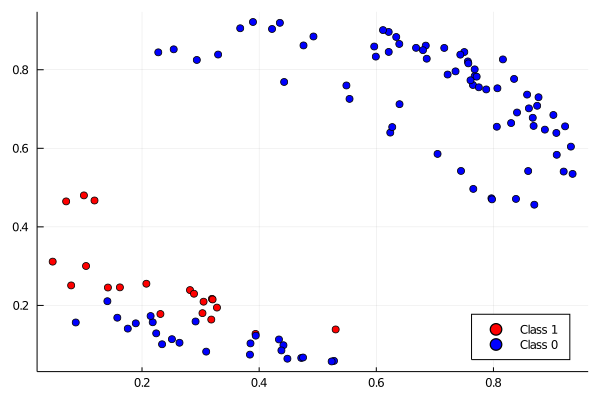

In [3]:
Random.seed!(1234)

# Data
datax, datay = create_data("../src/data/num-data.csv", sep = false)

# Codification
autoencoder = AutoEncoder(size(datax, 2), 2, sig)
grads, avg_err = autoencoder.learn_input(datax, η=0.9, α=0.3, epocs=200)
datax_red = autoencoder.reduce_dimensions(datax)

# Separation
datax_red_1 = datax_red[datay[:, 1] .== 1, :]
datax_red_0 = datax_red[datay[:, 1] .== 0, :]

# Plot reduced data
scatter(datax_red_1[:, 1], datax_red_1[:, 2], label="Class 1", color=:red)
scatter!(datax_red_0[:, 1], datax_red_0[:, 2], label="Class 0", color=:blue,
         legend=:bottomright)


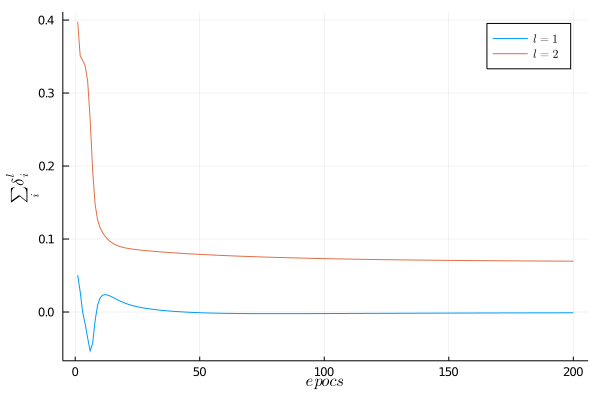

In [4]:
plot(grads, xlabel = L"epocs", ylabel = L"$\sum_i \delta_i^l$", label = [L"$l=1$" L"$l=2$"])


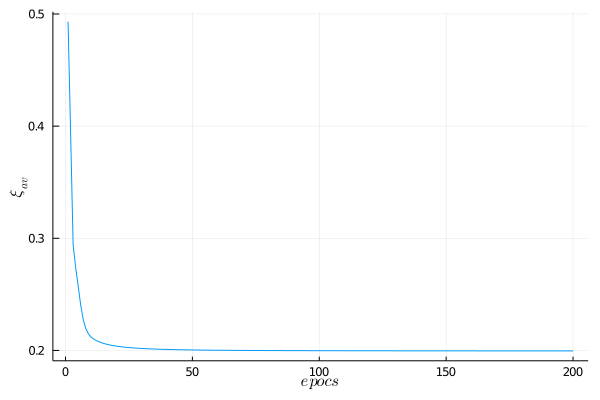

In [5]:
avg_err_plt = sum(avg_err / size(avg_err, 2), dims = 2)
plot(avg_err_plt, xlabel = L"epocs", ylabel = L"$\xi_{av}$", legend = false)


## Learn Data


In [6]:
brain = Brain(size(datax, 2), size(datay, 2), [3], [sig, sig])
brain_red = Brain(size(datax_red, 2), size(datay, 2), [3], [sig, sig])

# Data separation
train_data, _, _ = create_data("../src/data/num-data.csv",
                               indexes_file="../src/data/indexes.csv")
train_datax = train_data[1]
train_datay = train_data[2]
train_datax_red = autoencoder.reduce_dimensions(train_datax)

# Training
grads_br, avg_err_br = brain.learn_data(train_datax, train_datay, η=0.9, epocs=50)
grads_br_red, avg_err_br_red = brain_red.learn_data(train_datax_red, train_datay, η=0.9, epocs=50);


### Brain Higher Dimension


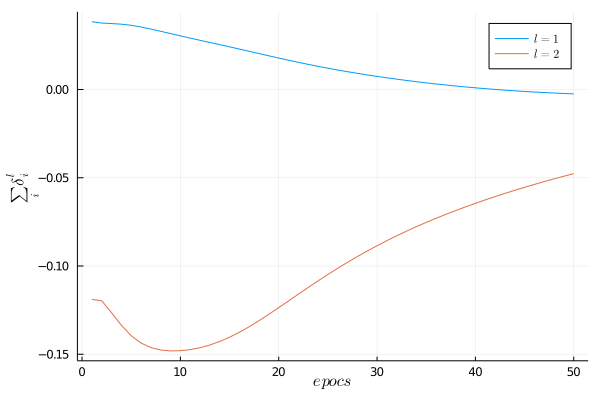

In [7]:
plot(grads_br, xlabel = L"epocs", ylabel = L"$\sum_i \delta_i^l$", label = [L"$l=1$" L"$l=2$"])


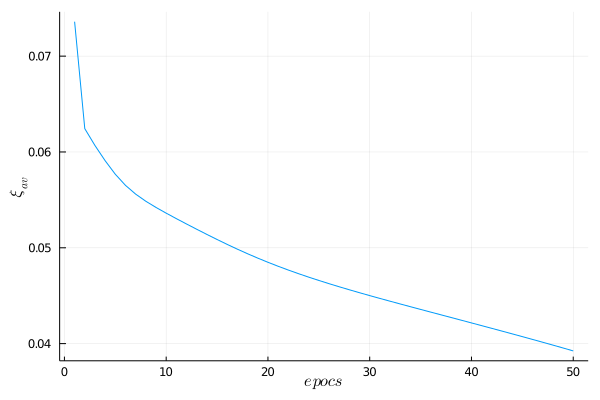

In [8]:
avg_err_plt_br = sum(avg_err_br / size(avg_err_br, 2), dims = 2)
plot(avg_err_plt_br, xlabel = L"epocs", ylabel = L"$\xi_{av}$", legend = false)


### Brain Reduced Dimension


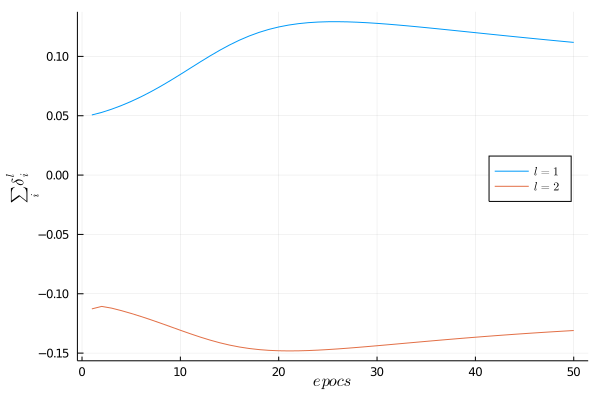

In [9]:
plot(grads_br_red, xlabel = L"epocs", ylabel = L"$\sum_i \delta_i^l$",
     label = [L"$l=1$" L"$l=2$"], legend = :right)


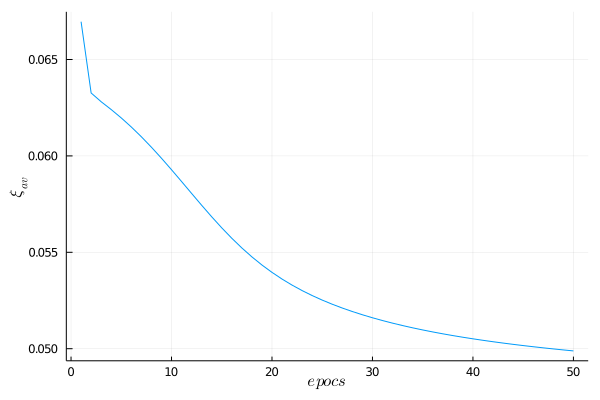

In [10]:
avg_err_plt_br_red = sum(avg_err_br_red / size(avg_err_br_red, 2), dims = 2)
plot(avg_err_plt_br_red, xlabel = L"epocs", ylabel = L"$\xi_{av}$", legend = false)


# LeNet 5
This code was based on an already implemented solution found in
[https://bit.ly/3l82TMX](this github repository). Most of the layers are
re-written for a better understanding and to follow the original article more
closely.


In [34]:
# Number of classes
nclass = 10

# Image size
x_pixels = 28
y_pixels = 28
depth = 1
imgsize = (x_pixels, y_pixels, depth)

# Layers
C1 = Conv((5, 5), depth => 6, relu)
S2 = MaxPool((2, 2))
C3 = Conv((5, 5), 6 => 16, relu)
S4 = MaxPool((2, 2))
C5 = Dense(256, 120, relu)
F6 = Dense(120, 84, relu)
out = Dense(84, nclass)

# Architecture
aux_reshape1 = x -> reshape(x, imgsize..., :)
aux_reshape2 = x -> reshape(x, :, size(x, 4))
lenet5 = Chain(aux_reshape1, C1, S2, C3, S4, aux_reshape2, C5, F6, out);


## Data Reading


In [51]:
# Data
xtrain, ytrain = MNIST.traindata(Float64)
xtrain = reshape(xtrain, imgsize..., :)

# Creating batch
ytrain = Flux.onehotbatch(ytrain, 0:9)
train_loader = Flux.Data.DataLoader(xtrain, ytrain, batchsize=128);


## Training


In [56]:
# Cuda model
model = lenet5 |> gpu

# Parameters
ps = Flux.params(lenet5)
opt = Flux.Optimise.Descent(3e-4)
loss(y_appr, y) = Flux.Losses.mse(y_appr, y)
epocs = 5

# Training
for epoc in 1:epocs
    p = ProgressMeter.Progress(length(train_loader))

    for (x, y) in train_loader
        x, y = x |> gpu, y |> gpu
        gs = Flux.gradient(ps) do
            y_appr = model(x)
            loss(y_appr, y)
        end
        Flux.Optimise.update!(opt, ps, gs)
        ProgressMeter.next!(p)
    end
end


Progress:   0%|▏                                        |  ETA: 6:29:51

Progress:   0%|▏                                        |  ETA: 3:15:33

Progress:   5%|██▏                                      |  ETA: 0:14:54

Progress:  10%|████▎                                    |  ETA: 0:07:12

Progress:  16%|██████▍                                  |  ETA: 0:04:34

Progress:  21%|████████▋                                |  ETA: 0:03:09

Progress:  27%|██████████▉                              |  ETA: 0:02:20

Progress:  32%|█████████████▎                           |  ETA: 0:01:46

Progress:  38%|███████████████▋                         |  ETA: 0:01:23

Progress:  42%|█████████████████▎                       |  ETA: 0:01:11

Progress:  48%|███████████████████▉                     |  ETA: 0:00:55

Progress:  55%|██████████████████████▌                  |  ETA: 0:00:42

Progress:  61%|█████████████████████████▏               |  ETA: 0:00:33

Progress:  68%|███████████████████████████▊             |  ETA: 0:00:25

Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:18

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:13

Progress:  86%|███████████████████████████████████▍     |  ETA: 0:00:08

Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:06

Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


Progress:   7%|██▊                                      |  ETA: 0:00:01

Progress:  13%|█████▍                                   |  ETA: 0:00:01

Progress:  19%|███████▉                                 |  ETA: 0:00:01

Progress:  25%|██████████▍                              |  ETA: 0:00:01

Progress:  31%|████████████▋                            |  ETA: 0:00:01

Progress:  36%|██████████████▊                          |  ETA: 0:00:01

Progress:  42%|█████████████████▎                       |  ETA: 0:00:01

Progress:  48%|███████████████████▋                     |  ETA: 0:00:01

Progress:  54%|██████████████████████▎                  |  ETA: 0:00:01

Progress:  61%|████████████████████████▉                |  ETA: 0:00:01

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01

Progress:  73%|█████████████████████████████▉           |  ETA: 0:00:00

Progress:  79%|████████████████████████████████▌        |  ETA: 0:00:00

Progress:  84%|██████████████████████████████████▍      |  ETA: 0:00:00

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


Progress:   7%|██▊                                      |  ETA: 0:00:01

Progress:  13%|█████▍                                   |  ETA: 0:00:01

Progress:  19%|████████                                 |  ETA: 0:00:01

Progress:  26%|██████████▋                              |  ETA: 0:00:01

Progress:  30%|████████████▍                            |  ETA: 0:00:01

Progress:  37%|███████████████                          |  ETA: 0:00:01

Progress:  43%|█████████████████▋                       |  ETA: 0:00:01

Progress:  49%|████████████████████▎                    |  ETA: 0:00:01

Progress:  56%|██████████████████████▉                  |  ETA: 0:00:01

Progress:  62%|█████████████████████████▌               |  ETA: 0:00:01

Progress:  69%|████████████████████████████▏            |  ETA: 0:00:01

Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:00

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:00

Progress:  86%|███████████████████████████████████▍     |  ETA: 0:00:00

Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


Progress:   6%|██▌                                      |  ETA: 0:00:02

Progress:  12%|█████▏                                   |  ETA: 0:00:01

Progress:  19%|███████▋                                 |  ETA: 0:00:01

Progress:  25%|██████████                               |  ETA: 0:00:01

Progress:  31%|████████████▋                            |  ETA: 0:00:01

Progress:  37%|███████████████▎                         |  ETA: 0:00:01

Progress:  43%|█████████████████▉                       |  ETA: 0:00:01

Progress:  50%|████████████████████▌                    |  ETA: 0:00:01

Progress:  56%|███████████████████████                  |  ETA: 0:00:01

Progress:  62%|█████████████████████████▋               |  ETA: 0:00:01

Progress:  69%|████████████████████████████▎            |  ETA: 0:00:01

Progress:  73%|██████████████████████████████▏          |  ETA: 0:00:00

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:00

Progress:  86%|███████████████████████████████████▍     |  ETA: 0:00:00

Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


Progress:   6%|██▋                                      |  ETA: 0:00:01

Progress:  13%|█████▏                                   |  ETA: 0:00:01

Progress:  19%|███████▊                                 |  ETA: 0:00:01

Progress:  25%|██████████▍                              |  ETA: 0:00:01

Progress:  31%|████████████▉                            |  ETA: 0:00:01

Progress:  38%|███████████████▌                         |  ETA: 0:00:01

Progress:  44%|██████████████████▏                      |  ETA: 0:00:01

Progress:  51%|████████████████████▊                    |  ETA: 0:00:01

Progress:  57%|███████████████████████▍                 |  ETA: 0:00:01

Progress:  63%|██████████████████████████               |  ETA: 0:00:01

Progress:  68%|███████████████████████████▉             |  ETA: 0:00:01

Progress:  74%|██████████████████████████████▌          |  ETA: 0:00:00

Progress:  81%|█████████████████████████████████▏       |  ETA: 0:00:00

Progress:  87%|███████████████████████████████████▊     |  ETA: 0:00:00

Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
